# PreTraining Undamaged Model

Objective: train a YOLO model on pre-event undamaged buildings (residential, commercial) to a sufficient level of accuracy. This model will be trained on an initial manually annotated dataset.

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


#### Initialization of Google Collab environment

In [2]:
requirements_packages = """
rasterio==1.4.2
ultralytics>=8.3
labelme2yolo==0.2.5
roboflow==1.1.48
"""

# Specify the file name
file_name = "requirements.txt"

# Write the text to the file
with open(file_name, 'w') as file:
    file.write(requirements_packages)

print(f"File '{file_name}' has been created with the text.")

File 'requirements.txt' has been created with the text.


In [3]:
# Installing required packages quietly without showing the details
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 

# Connecting to RoboFlow database

In [4]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


## Importing packages

In [5]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Define project details

In [6]:
# Downloading dataset from Roboflow platform (Notice: after execution data will be deleted from google colab)
roboflow_project_name = 'stormdamagechallenge'
dataset_name = 'storm-damage'
dataset_title = 'Storm-Damage'
dataset_id = 'goe2a'
dataset_version = 14 # Cleaned Commercial Buildings
model_name = 'yolo'
model_version = '11' # 'v8' or '11'
model_variant = 'n' # parameter required for model training phase

# Connect to roboflow dataset
rf = roboflow.Roboflow()
project = rf.workspace(roboflow_project_name).project(dataset_name + '-' + dataset_id)
dataset = project.version(dataset_version).download(model_name + model_version)

loading Roboflow workspace...
loading Roboflow project...

Version export complete for yolo11 format



Extracting Dataset Version Zip to Storm-Damage-14 in yolo11:: 100%|██████████| 774/774 [00:00<00:00, 3469.26it/s]


### Check Ultralytics connection

In [7]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
ultralytics.checks()

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.5/112.6 GB disk)


In [8]:
!nvidia-smi

Wed Aug  6 05:04:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Loading YOLO model for Training

In [9]:
# Loading the model
model = YOLO(f'../models/{model_name + model_version}/{model_name + model_version + model_variant}.pt')
# Display model information (optional)
model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

In [10]:
yaml_file = f'{HOME}/{dataset_title}-{dataset_version}/data.yaml'
yaml_file

'/content/Storm-Damage-14/data.yaml'

## Pre-Training Model

In [11]:
# Define model training parameters
batch = -1 # set as an integer (e.g., batch=16), auto mode for 60% GPU memory utilization (batch=-1), or auto mode with specified utilization fraction (batch=0.70)
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 50
patience = 10
imgsz = 640 # TODO: assess the importance of image size 640x640 by-design of Yolo models, image size role
plots = True
project = 'exploratory_phase' # parent directory name
name_train = f'{model_name + model_version + model_variant}_training_dataset_v{dataset_version}' # run directory name

In [12]:
# Train the model
result_model_training = model.train(
                                    data=yaml_file,
                                    batch = batch,
                                    device = device,
                                    epochs = epochs,
                                    patience = patience,
                                    imgsz = imgsz,
                                    optimizer = 'AdamW',
                                    # augment = False, # (bool) apply image augmentation to prediction sources
                                    lr0 = 1e-5,
                                    # auto_augment = None, # (str) auto augmentation policy for classification (randaugment, autoaugment, augmix)
                                    momentum = 0.937,
                                    plots = plots,
                                    project = project,
                                    name = name_train
                                    )

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Storm-Damage-14/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=1e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/yolo11/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_training_dataset_v14, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspe

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,230 parameters, 2,590,214 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1477.7±669.1 MB/s, size: 56.6 KB)


train: Scanning /content/Storm-Damage-14/train/labels... 333 images, 1 backgrounds, 0 corrupt: 100%|██████████| 333/333 [00:00<00:00, 2120.17it/s]

train: New cache created: /content/Storm-Damage-14/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.10G reserved, 0.07G allocated, 14.57G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590230       6.442         0.459         55.45         243.1        (1, 3, 640, 640)                    list
     2590230       12.88         0.631         29.49           106        (2, 3, 640, 640)                    list
     2590230       25.77         0.948         30.66         94.12        (4, 3, 640, 640)                    list
     2590230       51.53         1.617         33.41         107.8        (8, 3, 640, 640)                    list
     2590230       103.1         2.

train: Scanning /content/Storm-Damage-14/train/labels.cache... 333 images, 1 backgrounds, 0 corrupt: 100%|██████████| 333/333 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 753.4±709.7 MB/s, size: 62.2 KB)


val: Scanning /content/Storm-Damage-14/valid/labels... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<00:00, 403.92it/s]

val: New cache created: /content/Storm-Damage-14/valid/labels.cache


Plotting labels to exploratory_phase/yolo11n_training_dataset_v14/labels.jpg... 
optimizer: AdamW(lr=1e-05, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0004140625), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to exploratory_phase/yolo11n_training_dataset_v14
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.69G      2.281      3.705      1.928        335        640: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

                   all         32        842    0.00365      0.272    0.00422    0.00177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.78G      1.965      2.882       1.52        629        640: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         32        842    0.00146      0.241    0.00125   0.000311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.13G      1.862      2.122      1.461        332        640: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         32        842     0.0282      0.345      0.161     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.4G      1.845      1.901      1.455        480        640: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         32        842     0.0234      0.286      0.111     0.0339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.2G      1.875      1.771      1.465        552        640: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all         32        842      0.043       0.41     0.0764     0.0291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.96G      1.893      1.764      1.474        367        640: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         32        842     0.0761      0.482      0.115     0.0447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.05G       1.83      1.607      1.485        565        640: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         32        842     0.0453      0.529      0.138     0.0512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.1G      1.848      1.614      1.474        475        640: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         32        842     0.0431      0.538      0.159     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.33G      1.802      1.567      1.464        409        640: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         32        842      0.046      0.594       0.19     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.24G      1.816      1.543      1.466        506        640: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         32        842       0.05      0.689       0.27       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.42G      1.785       1.53      1.471        381        640: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         32        842     0.0517      0.707      0.335      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.89G      1.769      1.525      1.449        394        640: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         32        842     0.0539      0.765       0.36      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.32G      1.791      1.513      1.462        350        640: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all         32        842     0.0556      0.805       0.41      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.86G       1.79      1.493      1.447        538        640: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         32        842      0.777      0.192      0.449      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       9.1G      1.786      1.503      1.454        516        640: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         32        842      0.676      0.271      0.479       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.44G      1.789      1.498      1.446        372        640: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         32        842      0.613      0.367      0.504      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.23G      1.734      1.474       1.43        353        640: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         32        842      0.571      0.452      0.526      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.98G      1.759      1.533      1.436        239        640: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         32        842      0.594      0.492      0.539      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.7G      1.739      1.457      1.419        547        640: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         32        842      0.596      0.507      0.547      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.65G      1.754      1.474      1.429        435        640: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        842      0.598      0.541      0.555      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.77G       1.75      1.461      1.412        370        640: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         32        842      0.594      0.555      0.568       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.4G      1.744      1.459      1.419        473        640: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         32        842      0.589      0.566      0.561      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       9.3G      1.756      1.452      1.413        359        640: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         32        842       0.59      0.581      0.567      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.78G      1.747      1.466      1.426        603        640: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         32        842      0.621       0.57      0.567      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.69G      1.722      1.454      1.426        303        640: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         32        842      0.609      0.585      0.575      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.94G      1.705       1.44      1.411        308        640: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         32        842      0.585      0.589      0.575      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.13G      1.716      1.437      1.431        429        640: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         32        842      0.594       0.61      0.582      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.9G      1.745      1.451      1.431        472        640: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         32        842      0.584      0.624      0.587       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.83G      1.745      1.436      1.434        456        640: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         32        842      0.579      0.637       0.59      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.97G       1.73      1.441      1.419        391        640: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         32        842      0.573      0.654       0.59      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.35G      1.718      1.432      1.399        476        640: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         32        842      0.571      0.641      0.592      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.88G      1.714      1.438      1.409        430        640: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         32        842      0.585      0.648      0.596      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.2G       1.73      1.436      1.419        369        640: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         32        842      0.579      0.652      0.589      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.95G      1.756      1.451      1.402        333        640: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         32        842      0.577      0.644      0.587      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.94G      1.759      1.438      1.435        476        640: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         32        842      0.582      0.641      0.593      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.6G      1.723      1.398       1.42        446        640: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         32        842      0.571      0.634      0.589      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.68G      1.695      1.412      1.397        322        640: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         32        842      0.565      0.624      0.593      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.74G      1.707      1.423      1.405        387        640: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         32        842      0.569      0.629      0.596      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.11G      1.724      1.468      1.421        364        640: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         32        842      0.562      0.621      0.596      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.3G       1.73      1.405      1.398        365        640: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         32        842      0.565      0.632      0.597       0.29


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.22G      1.684       1.51       1.41        294        640: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         32        842      0.576      0.643      0.591      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       8.5G      1.727      1.584      1.466        239        640: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         32        842      0.564      0.641      0.584      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.46G       1.69      1.546      1.449        286        640: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         32        842      0.551      0.628      0.578      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.19G      1.696      1.609      1.452        181        640: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         32        842      0.566      0.621      0.577      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.94G      1.679      1.538      1.439        363        640: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         32        842      0.561      0.621       0.57      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.11G      1.689      1.512      1.444        332        640: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         32        842      0.572      0.616       0.57      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.49G      1.661      1.523       1.44        182        640: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         32        842      0.553      0.621      0.573       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.04G      1.684      1.495      1.453        274        640: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         32        842      0.563      0.619      0.573      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.95G      1.684      1.488      1.425        304        640: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         32        842      0.568      0.618      0.571      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.98G      1.677      1.505      1.458        265        640: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         32        842      0.561      0.622      0.571      0.268
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



50 epochs completed in 0.093 hours.
Optimizer stripped from exploratory_phase/yolo11n_training_dataset_v14/weights/last.pt, 5.5MB
Optimizer stripped from exploratory_phase/yolo11n_training_dataset_v14/weights/best.pt, 5.5MB

Validating exploratory_phase/yolo11n_training_dataset_v14/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


                   all         32        842      0.567      0.632      0.597       0.29
undamagedcommercialbuilding         14         58      0.507      0.517      0.456      0.244
undamagedresidentialbuilding         29        784      0.626      0.746      0.738      0.335
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to exploratory_phase/yolo11n_training_dataset_v14


In [13]:
metrics = model.val()
metrics.box.map # map50-95
metrics.box.map50 # map50
metrics.box.map75 # map75
metrics.box.maps # a list contains map50-95 of each category

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 946.6±531.1 MB/s, size: 55.8 KB)


val: Scanning /content/Storm-Damage-14/valid/labels.cache... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


                   all         32        842      0.564      0.631      0.597      0.289
undamagedcommercialbuilding         14         58      0.503      0.517      0.457      0.241
undamagedresidentialbuilding         29        784      0.625      0.745      0.738      0.336
Speed: 0.3ms preprocess, 11.1ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to exploratory_phase/yolo11n_training_dataset_v142


array([    0.24141,     0.33633])

In [ ]:
metrics = model.val()
metrics.box.map # map50-95
metrics.box.map50 # map50
metrics.box.map75 # map75
metrics.box.maps # a list contains map50-95 of each category

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1180.4±390.2 MB/s, size: 55.8 KB)


val: Scanning /content/Storm-Damage-14/valid/labels.cache... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


                   all         32        842      0.651      0.555      0.591      0.289
undamagedcommercialbuilding         14         58      0.576      0.445      0.441      0.241
undamagedresidentialbuilding         29        784      0.726      0.665      0.741      0.336
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to exploratory_phase/yolo11n_training_dataset_v142


array([    0.24123,     0.33584])

In [14]:
metrics.box.map50

np.float64(0.5971192128868948)

In [16]:
from google.colab import files
files.download("/content/exploratory_phase/yolo11n_training_dataset_v14")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
metrics.box.fitness

<bound method Metric.fitness of ultralytics.utils.metrics.Metric object with attributes:

all_ap: array([[    0.45671,     0.43871,     0.40709,     0.37534,       0.254,     0.24833,     0.14325,    0.086312,    0.003748,  0.00055324],
       [    0.73753,     0.68615,     0.62947,     0.52417,     0.41966,     0.23434,    0.098294,    0.028749,   0.0044693,  0.00046291]])
ap: array([    0.24141,     0.33633])
ap50: array([    0.45671,     0.73753])
ap_class_index: array([0, 1])
curves: []
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    0.049049,     0.05005,    0.051051,    0.052052,    0.053053,    0.054054,    0.055055,    0.056056,    0.057057,    0.058058,    0.059059,     0.06006,    0.061061,    0.062062,    0.063063,    0.064064,    0.065065,    0.066066,    0.067067,    0.068068,    0.069069,     0.07007,    0.071071,
          0.072072,    0.073073,    0.074074,    0.075075,    0.076076,    0.077077,    0.078078,    0.079079,     0.08008,    0.081081,    0.082082,    0.083083,    0.084084,    0.085085,    0.086086,    0.087087,    0.088088,    0.089089,     0.09009,    0.091091,    0.092092,    0.093093,    0.094094,    0.095095,
          0.096096,    0.097097,    0.098098,    0.099099,      0.1001,      0.1011,      0.1021,      0.1031,      0.1041,     0.10511,     0.10611,     0.10711,     0.10811,     0.10911,     0.11011,     0.11111,     0.11211,     0.11311,     0.11411,     0.11512,     0.11612,     0.11712,     0.11812,     0.11912,
           0.12012,     0.12112,     0.12212,     0.12312,     0.12412,     0.12513,     0.12613,     0.12713,     0.12813,     0.12913,     0.13013,     0.13113,     0.13213,     0.13313,     0.13413,     0.13514,     0.13614,     0.13714,     0.13814,     0.13914,     0.14014,     0.14114,     0.14214,     0.14314,
           0.14414,     0.14515,     0.14615,     0.14715,     0.14815,     0.14915,     0.15015,     0.15115,     0.15215,     0.15315,     0.15415,     0.15516,     0.15616,     0.15716,     0.15816,     0.15916,     0.16016,     0.16116,     0.16216,     0.16316,     0.16416,     0.16517,     0.16617,     0.16717,
           0.16817,     0.16917,     0.17017,     0.17117,     0.17217,     0.17317,     0.17417,     0.17518,     0.17618,     0.17718,     0.17818,     0.17918,     0.18018,     0.18118,     0.18218,     0.18318,     0.18418,     0.18519,     0.18619,     0.18719,     0.18819,     0.18919,     0.19019,     0.19119,
           0.19219,     0.19319,     0.19419,      0.1952,      0.1962,      0.1972,      0.1982,      0.1992,      0.2002,      0.2012,      0.2022,      0.2032,      0.2042,     0.20521,     0.20621,     0.20721,     0.20821,     0.20921,     0.21021,     0.21121,     0.21221,     0.21321,     0.21421,     0.21522,
           0.21622,     0.21722,     0.21822,     0.21922,     0.22022,     0.22122,     0.22222,     0.22322,     0.22422,     0.22523,     0.22623,     0.22723,     0.22823,     0.22923,     0.23023,     0.23123,     0.23223,     0.23323,     0.23423,     0.23524,     0.23624,     0.23724,     0.23824,     0.23924,
           0.24024,     0.24124,     0.24224,     0.24324,     0.24424,     0.24525,     0.24625,     0.24725,     0.24825,     0.24925,     0.25025,     0.25125,     0.25225,     0.25325,     0.25425,     0.25526,     0.25626,     0.25726,     0.25826,     0.25926,     0.26026,     0.26126,    

## Use trained model for inference

In [20]:
os

<module 'os' (frozen)>

In [27]:
images_inference = ['/content/images_inference/'+filename for filename in os.listdir("/content/images_inference")]
images_inference

['/content/images_inference/Pre_Event_tile_0_40.jpg',
 '/content/images_inference/Pre_Event_tile_0_39.jpg',
 '/content/images_inference/Pre_Event_tile_0_46.jpg',
 '/content/images_inference/Pre_Event_tile_0_41.jpg',
 '/content/images_inference/Pre_Event_tile_0_43.jpg',
 '/content/images_inference/Pre_Event_tile_0_45.jpg',
 '/content/images_inference/Pre_Event_tile_0_42.jpg',
 '/content/images_inference/Pre_Event_tile_0_44.jpg']

In [105]:
list_images = ["/content/Pre_Event_tile_2_24.jpg", "/content/Pre_Event_tile_2_26.jpg"]
inference_results = model.predict(images_inference, save=False, imgsz=640, conf=0.2)


0: 640x640 8 undamagedcommercialbuildings, 4.9ms
1: 640x640 7 undamagedcommercialbuildings, 2 undamagedresidentialbuildings, 4.9ms
2: 640x640 102 undamagedresidentialbuildings, 4.9ms
3: 640x640 4 undamagedcommercialbuildings, 1 undamagedresidentialbuilding, 4.9ms
4: 640x640 7 undamagedcommercialbuildings, 37 undamagedresidentialbuildings, 4.9ms
5: 640x640 165 undamagedresidentialbuildings, 4.9ms
6: 640x640 9 undamagedcommercialbuildings, 16 undamagedresidentialbuildings, 4.9ms
7: 640x640 61 undamagedresidentialbuildings, 4.9ms
Speed: 2.1ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


In [106]:
type(inference_results[0])

ultralytics.engine.results.Results

In [107]:
len(inference_results[3])

5

In [111]:
inference_results[1].names

{0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding'}

In [121]:
inference_results[1]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding'}
obb: None
orig_img: array([[[ 56,  91,  47],
        [ 55,  90,  46],
        [ 55,  90,  46],
        ...,
        [ 36,  54,  31],
        [ 37,  55,  32],
        [ 36,  54,  31]],

       [[ 56,  91,  47],
        [ 56,  91,  47],
        [ 57,  92,  48],
        ...,
        [ 28,  46,  23],
        [ 35,  53,  30],
        [ 39,  57,  34]],

       [[ 54,  89,  45],
        [ 55,  90,  46],
        [ 56,  91,  47],
        ...,
        [ 29,  47,  24],
        [ 36,  55,  30],
        [ 40,  59,  34]],

       ...,

       [[216, 220, 225],
        [215, 219, 224],
        [215, 219, 224],
        ...,
        [ 94,  96,  97],
        [ 92,  94,  95],
        [ 92,  94,  95]],

       [[216, 220, 225],
        [216, 220, 225],
        [216, 220, 225],
        ...,
       

In [118]:
inference_results[1].boxes.cls.cpu().numpy()

array([          0,           0,           0,           1,           0,           0,           1,           0,           0], dtype=float32)

In [119]:
inference_results[1].boxes.conf.cpu().numpy()

array([    0.86175,     0.78157,     0.57962,     0.49385,     0.42382,     0.29368,     0.23214,     0.21685,     0.20087], dtype=float32)

In [122]:
inference_results[1].path

'/content/images_inference/Pre_Event_tile_0_39.jpg'

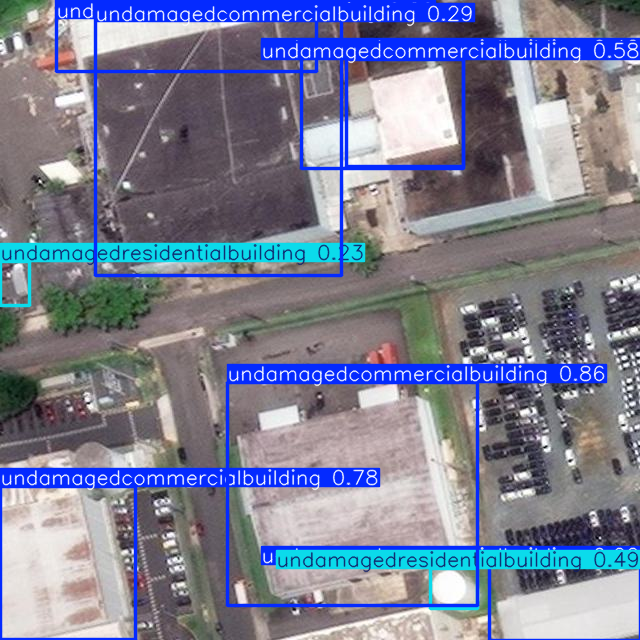

In [110]:
inference_results[1].show()

In [123]:
# Writing a scrypt that iterates over all the images in the list of results in model predict
# Iterate over all files, select the paths of results images which contain commercial buildings with high enough confidence > 0.8
# store all these paths in a list the use it to select these files in a folder on the local machine
# then upload them to roboflow for manual annotation and extension of the dataset

In [124]:
len(inference_results)

8

In [128]:
images_containing_commercial_buildings : list[str] = []

for i, image in enumerate(inference_results):
  print(i, image.boxes.conf.cpu().numpy())

0 [    0.93725      0.8513     0.42605     0.34515      0.2827     0.28238     0.27048     0.23076]
1 [    0.86175     0.78157     0.57962     0.49385     0.42382     0.29368     0.23214     0.21685     0.20087]
2 [    0.85169     0.83837     0.80984     0.79786     0.78243     0.78223     0.75819     0.75612     0.74783     0.73938      0.7241     0.72009     0.71589     0.71236     0.68779     0.68411     0.68256     0.66273     0.63952      0.6344     0.63417     0.62713     0.62296      0.6197     0.61731     0.61604
     0.60864      0.6075     0.59267     0.58911     0.58509     0.58447     0.57695     0.56383     0.55329     0.53523     0.52881     0.52828     0.52802     0.52613     0.52387     0.51321     0.50639     0.49846     0.49411     0.48833      0.4882     0.48798     0.48411      0.4758     0.47281     0.47071
     0.46911     0.46804     0.46419     0.46336     0.46171     0.45909     0.45522     0.45463     0.44888     0.42622     0.40303     0.39525     0.37956    

In [31]:
inference_results[0].boxes.cls[0]

tensor(0., device='cuda:0')

In [33]:
inference_results[0].names


{0: 'undamagedcommercialbuilding', 1: 'undamagedresidentialbuilding'}